In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import numpy as np

# Human Survey

In [2]:
prob_words = pd.read_csv("https://raw.githubusercontent.com/wadefagen/datasets/master/Perception-of-Probability-Words/survey-results.csv")

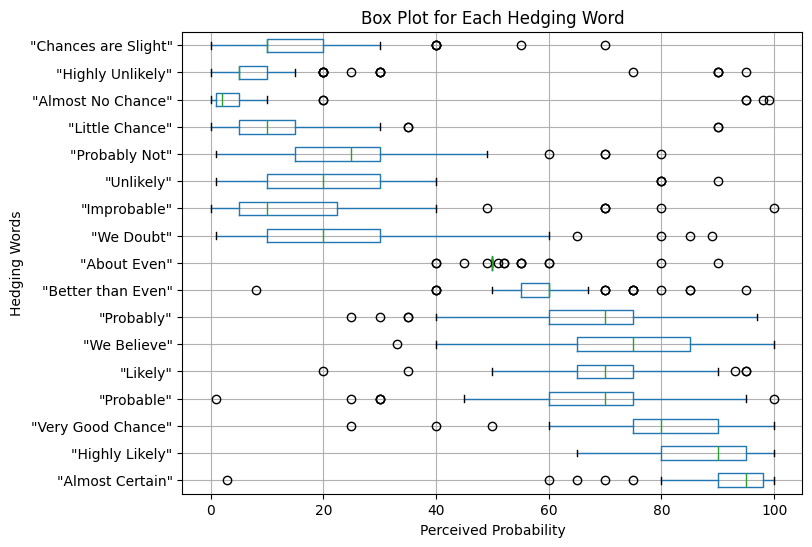

In [3]:
prob_words.boxplot(vert=False, figsize=(8,6))
plt.title('Box Plot for Each Hedging Word')
plt.ylabel('Hedging Words')
plt.xlabel('Perceived Probability')
plt.grid(True)
plt.show()

# Hedging Word Extractor

In [4]:
HEDGING_EXPRESSIONS = [
    "almost certain", "highly likely", "very likely", "probable",
    "somewhat likely", "possible", "uncertain", "somewhat unlikely",
    "unlikely", "not likely", "doubtful", "very unlikely", "highly unlikely"
]

EXTENDED_HEDGES = [
    "might", "may", "could", "possibly", "it is believed", "seems", "suggests", "tends to", 
    "presumably", "apparently", "assumed", "allegedly", "estimate", "speculate"
]

ALL_HEDGING_WORDS = HEDGING_EXPRESSIONS + EXTENDED_HEDGES
hedging_word_map = {h: [] for h in ALL_HEDGING_WORDS}
hedging_word_map

{'almost certain': [],
 'highly likely': [],
 'very likely': [],
 'probable': [],
 'somewhat likely': [],
 'possible': [],
 'uncertain': [],
 'somewhat unlikely': [],
 'unlikely': [],
 'not likely': [],
 'doubtful': [],
 'very unlikely': [],
 'highly unlikely': [],
 'might': [],
 'may': [],
 'could': [],
 'possibly': [],
 'it is believed': [],
 'seems': [],
 'suggests': [],
 'tends to': [],
 'presumably': [],
 'apparently': [],
 'assumed': [],
 'allegedly': [],
 'estimate': [],
 'speculate': []}

In [5]:
def extract_hedging_words(text, hedge_list=HEDGING_EXPRESSIONS):
    found = []
    text_lower = text.lower()
    for hedge in hedge_list:
        # Escape special regex chars, and ensure whole word/phrase match
        pattern = r'\b' + re.escape(hedge) + r'\b'
        if re.search(pattern, text_lower):
            found.append(hedge)
    return found

In [6]:
text = "It is highly likely that the model will generalize well. However, there is still some uncertainty."
print(extract_hedging_words(text))

['highly likely']


# LLM Response Analysis

In [7]:
def get_confidence(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    # Parse the HTML
    soup = BeautifulSoup(html_content, "html.parser")

    # Define a regex pattern for "Extracted Answer Confidence"
    pattern = re.compile(r"Extracted Answer Confidence:\s*([0-9]*\.?[0-9]+)", re.IGNORECASE)

    # Search through the text in the HTML
    matches = pattern.findall(soup.get_text())

    # Print the extracted confidence values
    return np.array(matches, dtype=float)

In [8]:
def extract_pre_from_assistant_blocks(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    soup = BeautifulSoup(html_content, 'html.parser')
    pre_blocks = []

    # Find all <div class="message assistant">
    assistant_divs = soup.find_all("div", class_="message assistant")
    
    for div in assistant_divs:
        # Within each assistant message, find all <pre> tags
        pre_tags = div.find_all("pre")
        for pre in pre_tags:
            pre_blocks.append(pre.get_text(strip=True))

    return pre_blocks

In [9]:
path = "../results/gpqa_Llama-3.3-70B-Instruct-Turbo-Free_verbal_linguistic_None.html"


In [12]:
responses = extract_pre_from_assistant_blocks(path)
uncertainty = get_confidence(path)

In [ ]:
extract_hedging_words()